In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import tensorflow as tf
from random import sample
from os import mkdir, listdir
from collections import Counter
import matplotlib.pyplot as plt
from shutil import copyfile, rmtree
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_dir = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train"
valid_dir = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val"
test_dir = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"

In [3]:
target_size = (1300, 650)

def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
            if image is None:
                continue  
            image = cv2.resize(image, target_size)  
            image = image / 255.0  
            images.append(image)
            labels.append(label)
    images = np.array(images).reshape(-1, target_size[0], target_size[1], 1)  
    return images, labels

# Load datasets
train_images, train_labels = load_images_from_directory(train_dir, target_size)
valid_images, valid_labels = load_images_from_directory(valid_dir, target_size)
test_images, test_labels = load_images_from_directory(test_dir, target_size)


Training Set Samples:


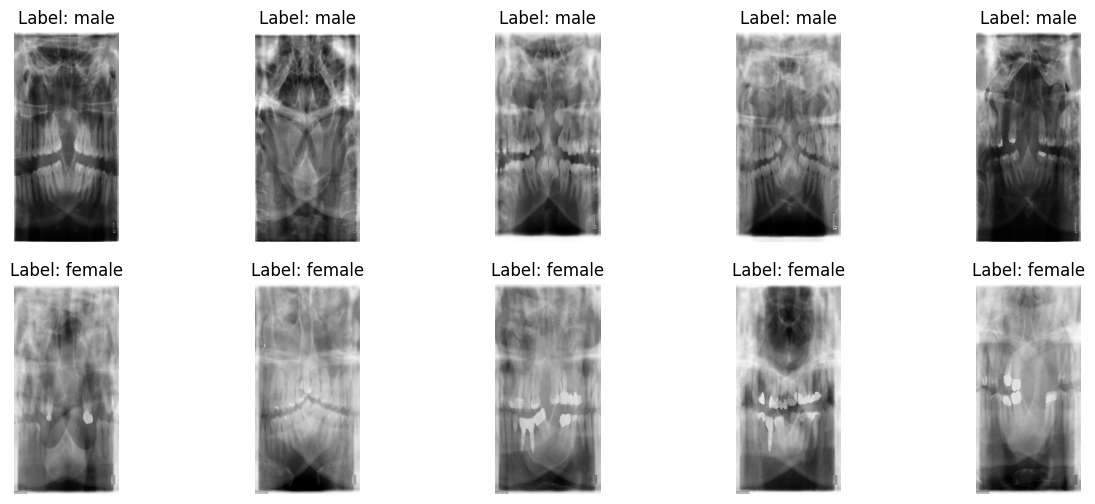

In [4]:
def display_images(images, labels, num_images=5):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(len(unique_labels), num_images, figsize=(15, len(unique_labels)*3))
    for i, label in enumerate(unique_labels):
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        for j in range(num_images):
            if j < len(label_images):
                ax = axes[i, j]
                ax.imshow(label_images[j].reshape(target_size[0], target_size[1]), cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"Label: {label}")
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.show()

print("Training Set Samples:")
display_images(train_images, train_labels)


In [5]:
# Label encoding
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# Convert to numpy arrays
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

# Shuffle training data
def shuffle_data(images, labels):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], labels[indices]

train_images, train_labels = shuffle_data(train_images, train_labels)


In [6]:
# Create feature extractor
feature_extractor = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(1300, 650, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D()
])

# Extract features
print("Extracting training features...")
train_features = feature_extractor.predict(train_images)
print("Extracting validation features...")
valid_features = feature_extractor.predict(valid_images)
print("Feature extraction complete!")

Extracting training features...
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step
Extracting validation features...
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
Feature extraction complete!


In [7]:
def pso_feature_selection(X, y, n_particles=10, n_iterations=20):
    n_features = X.shape[1]
    particles = np.random.randint(0, 2, (n_particles, n_features))
    velocities = np.zeros((n_particles, n_features))
    personal_best = particles.copy()
    personal_best_scores = np.zeros(n_particles)
    global_best = particles[0].copy()
    global_best_score = -np.inf

    for _ in range(n_iterations):
        for i in range(n_particles):
            mask = particles[i].astype(bool)
            if np.sum(mask) == 0:
                score = 0.0
            else:
                X_subset = X[:, mask]
                X_train, X_val, y_train, y_val = train_test_split(X_subset, y, test_size=0.2, random_state=42)
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X_train, y_train)
                score = clf.score(X_val, y_val)
            
            if score > personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best[i] = particles[i].copy()
            
            if score > global_best_score:
                global_best_score = score
                global_best = particles[i].copy()

        w = 0.9
        c1 = 0.5
        c2 = 0.5
        for i in range(n_particles):
            r1 = np.random.rand(n_features)
            r2 = np.random.rand(n_features)
            velocities[i] = (w * velocities[i] + 
                            c1 * r1 * (personal_best[i] - particles[i]) + 
                            c2 * r2 * (global_best - particles[i]))
            particles[i] = np.where(np.random.rand(n_features) < 1/(1+np.exp(-velocities[i])), 1, 0)

    return global_best

def gwo_feature_selection(X, y, n_wolves=10, n_iterations=20):
    n_features = X.shape[1]
    wolves = np.random.randint(0, 2, (n_wolves, n_features))
    alpha = wolves[0].copy()
    beta = wolves[1].copy()
    delta = wolves[2].copy()
    alpha_score = -np.inf

    for iter in range(n_iterations):
        for i in range(n_wolves):
            mask = wolves[i].astype(bool)
            if np.sum(mask) == 0:
                score = 0.0
            else:
                X_subset = X[:, mask]
                X_train, X_val, y_train, y_val = train_test_split(X_subset, y, test_size=0.2, random_state=42)
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X_train, y_train)
                score = clf.score(X_val, y_val)
            
            if score > alpha_score:
                alpha_score = score
                alpha = wolves[i].copy()
            elif score > alpha_score * 0.9:
                beta = wolves[i].copy()
            elif score > alpha_score * 0.8:
                delta = wolves[i].copy()

        a = 2 - 2 * (iter/n_iterations)
        for i in range(n_wolves):
            A1 = 2 * a * np.random.rand(n_features) - a
            C1 = 2 * np.random.rand(n_features)
            D_alpha = np.abs(C1 * alpha - wolves[i])
            X1 = alpha - A1 * D_alpha

            A2 = 2 * a * np.random.rand(n_features) - a
            C2 = 2 * np.random.rand(n_features)
            D_beta = np.abs(C2 * beta - wolves[i])
            X2 = beta - A2 * D_beta

            A3 = 2 * a * np.random.rand(n_features) - a
            C3 = 2 * np.random.rand(n_features)
            D_delta = np.abs(C3 * delta - wolves[i])
            X3 = delta - A3 * D_delta

            new_position = (X1 + X2 + X3) / 3
            wolves[i] = np.where(np.random.rand(n_features) < 1/(1+np.exp(-new_position)), 1, 0)

    return alpha

print("Running PSO feature selection...")
best_mask_pso = pso_feature_selection(train_features, train_labels)
print("Running GWO feature selection...")
best_mask_gwo = gwo_feature_selection(train_features, train_labels)

# Combine feature selections
final_mask = np.logical_or(best_mask_pso, best_mask_gwo).astype(np.float32)
print(f"Selected {np.sum(final_mask)} features out of {len(final_mask)}")


Running PSO feature selection...
Running GWO feature selection...
Selected 41.0 features out of 64


In [8]:
# Create mask layer
mask_layer = Lambda(lambda x: x * final_mask)

# Build final model
CNN_Model = Sequential([
    feature_extractor,
    mask_layer,
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

CNN_Model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

CNN_Model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,089 (98.00 KB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = CNN_Model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(valid_images, valid_labels),
    batch_size=8,
    verbose=1
)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.5032 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 331s 4s/step - accuracy: 0.5450 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.4843 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.6880
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.5379 - loss: 0.6882 - val_accuracy: 0.5000 - val_loss: 0.6858
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.5285 - loss: 0.6841 - val_accuracy: 0.5000 - val_loss: 0.6821
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.5294 - loss: 0.6810 - val_accuracy: 0.5000 - val_loss: 0.6789
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.5584 - loss: 0.6771 - val_accuracy: 0.6020 - val_loss: 0.6734
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.5962 - loss: 0.6736 - val_accuracy: 0.6327 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7971 - loss: 0.6353

Test Accuracy: 69.07%
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report:
              precision    recall  f1-score   support

      female       0.62      1.00      0.77        49
        male       1.00      0.38      0.55        48

    accuracy                           0.69        97
   macro avg       0.81      0.69      0.66        97
weighted avg       0.81      0.69      0.66        97



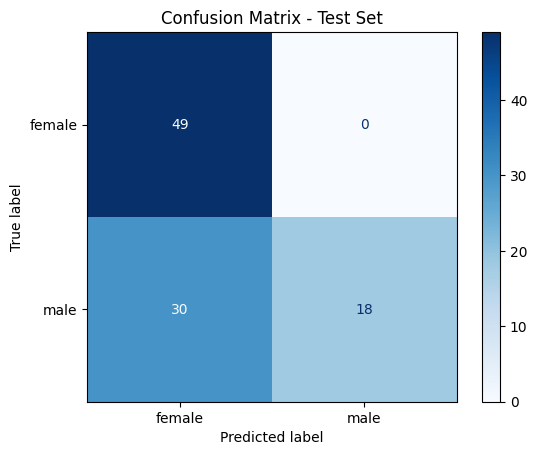

In [10]:
# Evaluate on test set
test_loss, test_accuracy = CNN_Model.evaluate(test_images, test_labels)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Classification Report
y_pred_probs = CNN_Model.predict(test_images)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [13]:
# Save model
CNN_Model.save('gender_classification_pso_gwo.h5')

# Load model for demonstration
loaded_model = load_model('gender_classification_pso_gwo.h5')


ValueError: Layer count mismatch when loading weights from file. Model expected 1 layers, found 4 saved layers.

In [12]:
def predict_gender(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    processed_image = cv2.resize(image, target_size) / 255.0
    processed_image = np.expand_dims(processed_image, axis=(0, -1))
    
    prediction = loaded_model.predict(processed_image)
    predicted_class = "Male" if prediction[0][0] > 0.5 else "Female"
    
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Gender: {predicted_class}\nConfidence: {abs(prediction[0][0]-0.5)*200:.1f}%")
    plt.axis('off')
    plt.show()

# Example usage
test_image_path = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\female\\female.445.JPG"
predict_gender(test_image_path)

NameError: name 'loaded_model' is not defined